Harnessing the Power of Data
Specific data analytics techniques vary based on the organization and audit, but a few common examples are:

Identifying Outliers – Data analytics can help to identify patterns and anomalies within datasets that may be indicative of operational inefficiencies, control gaps, or potential fraud (see example below).

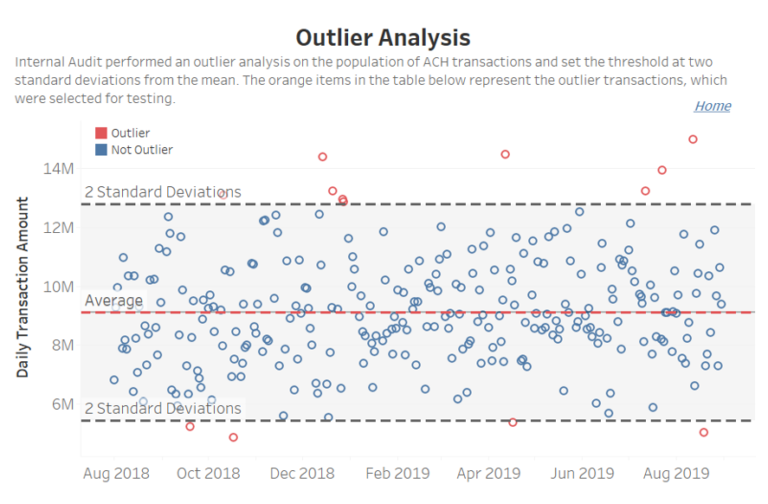

# Import data into Python and surface outliers in the dataset

In [1]:
import pyodbc
import urllib
import sqlalchemy
import pandas as pd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab
# pd.set_option('display.max_colwidth', False)
import re

'''connect to datahub'''

params_datahub = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=datahub;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_datahub = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_datahub))

In [2]:
df_outlier=pd.read_sql_table('audit_outlier_data',engine_datahub )
df_outlier

,user_id,birth_year_month,number_of_posts,number_of_comments
0,1,6/1/1986,912.0,18.0
1,2,6/1/1991,29.0,13.0
2,3,9/2/1960,240.0,44.0
3,4,11/1/1977,839.0,7.0
4,5,3/1/1980,515.0,39.0
...,...,...,...,...
548,549,11/1/1988,237.0,22.0
549,550,4/1/1994,8887.0,14.0
550,551,4/1/1987,NaN,NaN
551,552,4/1/1984,442.0,28.0


In [3]:
df_outlier.info()
df_outlier.dropna(inplace=True)
df_outlier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             553 non-null    object 
 1   birth_year_month    552 non-null    object 
 2   number_of_posts     552 non-null    float64
 3   number_of_comments  551 non-null    float64
dtypes: float64(2), object(2)
memory usage: 17.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 0 to 552
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             550 non-null    object 
 1   birth_year_month    550 non-null    object 
 2   number_of_posts     550 non-null    float64
 3   number_of_comments  550 non-null    float64
dtypes: float64(2), object(2)
memory usage: 21.5+ KB


#### Identify outliers for birth_year_month using 1% and 99% quantiles. 

In [4]:
import datetime
def excel_date(date1):
    temp = datetime.datetime(1899, 12, 30)    # Note, not 31st Dec but 30th!
    delta = date1 - temp
    return float(delta.days) + (float(delta.seconds) / 86400)

In [5]:
pd.to_datetime(df_outlier['birth_year_month'])

0     1986-06-01
1     1991-06-01
2     1960-09-02
3     1977-11-01
4     1980-03-01
         ...    
547   1980-08-01
548   1988-11-01
549   1994-04-01
551   1984-04-01
552   1962-09-01
Name: birth_year_month, Length: 550, dtype: datetime64[ns]

In [6]:
#convert datetime to numbers
df_outlier['birth_year_month']=pd.to_datetime(df_outlier['birth_year_month'])
df_outlier['birth_year_month_number']=df_outlier['birth_year_month'].apply(lambda x: excel_date(x))

In [7]:
df_outlier

,user_id,birth_year_month,number_of_posts,number_of_comments,birth_year_month_number
0,1,1986-06-01,912.0,18.0,31564.0
1,2,1991-06-01,29.0,13.0,33390.0
2,3,1960-09-02,240.0,44.0,22161.0
3,4,1977-11-01,839.0,7.0,28430.0
4,5,1980-03-01,515.0,39.0,29281.0
...,...,...,...,...,...
547,548,1980-08-01,917.0,44.0,29434.0
548,549,1988-11-01,237.0,22.0,32448.0
549,550,1994-04-01,8887.0,14.0,34425.0
551,552,1984-04-01,442.0,28.0,30773.0


In [8]:
col='birth_year_month_number'
Q1 = df_outlier[col].quantile(0.01) #lower 1%
Q3 = df_outlier[col].quantile(0.99) #higher 1%

IQR = Q3 - Q1

In [9]:
Q1

21929.59

In [12]:
~(df_outlier[col] >= (Q1)) & (df_outlier[col] <= (Q3))

0      False
1      False
2      False
3      False
4      False
       ...  
547    False
548    False
549    False
551    False
552    False
Name: birth_year_month_number, Length: 550, dtype: bool

In [14]:
df_outlier[['user_id','birth_year_month',col]][~(df_outlier[col] >= (Q1)) & (df_outlier[col] <= (Q3))]

,user_id,birth_year_month,birth_year_month_number
58,59,1959-12-01,21885.0
63,64,1922-09-01,8280.0
378,379,1959-06-01,21702.0
397,398,1959-03-01,21610.0
404,405,1959-07-01,21732.0
426,427,1959-02-01,21582.0


In [15]:
xf = df_outlier[['user_id','birth_year_month',col]][~((df_outlier[col] >= (Q1)) & (df_outlier[col] <= (Q3)))]
xf

,user_id,birth_year_month,birth_year_month_number
58,59,1959-12-01,21885.0
61,62,2020-07-01,44013.0
63,64,1922-09-01,8280.0
73,74,2001-09-01,37135.0
218,219,2010-08-01,40391.0
282,283,2001-11-01,37196.0
378,379,1959-06-01,21702.0
389,390,2001-10-01,37165.0
397,398,1959-03-01,21610.0
404,405,1959-07-01,21732.0


C:\Users\ABC\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


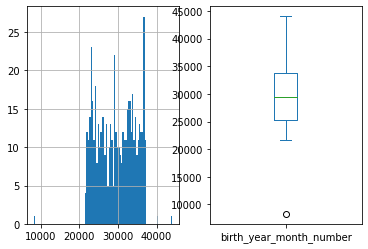

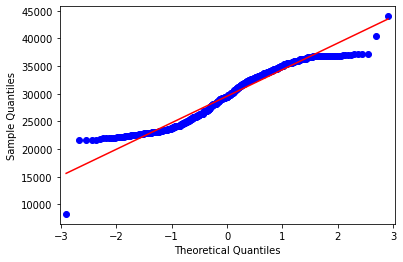

Outliers:
    user_id birth_year_month  birth_year_month_number
63       64       1922-09-01                   8280.0
426     427       1959-02-01                  21582.0
397     398       1959-03-01                  21610.0
378     379       1959-06-01                  21702.0
404     405       1959-07-01                  21732.0
58       59       1959-12-01                  21885.0
73       74       2001-09-01                  37135.0
540     541       2001-09-01                  37135.0
389     390       2001-10-01                  37165.0
282     283       2001-11-01                  37196.0
218     219       2010-08-01                  40391.0
61       62       2020-07-01                  44013.0


count      550.000000
mean     29565.401818
std       4801.397775
min       8280.000000
25%      25294.000000
50%      29465.000000
75%      33695.000000
max      44013.000000
Name: birth_year_month_number, dtype: float64

<Figure size 432x288 with 0 Axes>

In [16]:
plt.subplot(1,2,1)
df_outlier[col].hist(bins=100)

plt.subplot(1,2,2)
df_outlier[col].plot(kind='box')

sm.qqplot(df_outlier[col],line='s')
pylab.show()

plt.tight_layout()
print('Outliers:')
print(xf.sort_values(by=col))
df_outlier[col].describe()

#### Identify outliers for number_of_posts using 1% and 99% quantiles. 

C:\Users\ABC\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


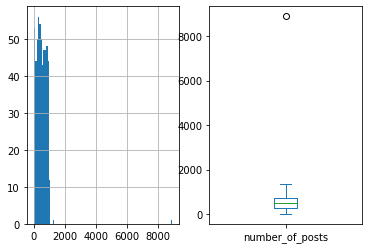

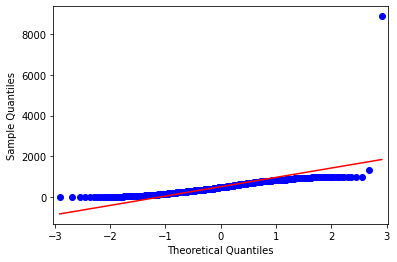

Outliers:
    user_id  number_of_posts
36       37              0.0
514     515              0.0
35       36              7.0
100     101              8.0
388     389              9.0
348     349             10.0
115     116            991.0
298     299            991.0
415     416            995.0
375     376            996.0
47       48           1332.0
549     550           8887.0


count     550.000000
mean      504.607273
std       460.070849
min         0.000000
25%       249.000000
50%       485.000000
75%       741.750000
max      8887.000000
Name: number_of_posts, dtype: float64

<Figure size 432x288 with 0 Axes>

In [17]:
col='number_of_posts'

Q1 = df_outlier[col].quantile(0.01) #lower 1%
Q3 = df_outlier[col].quantile(0.99) #higher 1%

IQR = Q3 - Q1
xf = df_outlier[['user_id',col]][~((df_outlier[col] >= (Q1)) & (df_outlier[col] <= (Q3)))]
plt.subplot(1,2,1)
df_outlier[col].hist(bins=100)
plt.subplot(1,2,2)
df_outlier[col].plot(kind='box')
sm.qqplot(df_outlier[col],line='s')
pylab.show()
plt.tight_layout()
print('Outliers:')
print(xf.sort_values(by=col))
df_outlier[col].describe()

#### Identify outliers for number_of_comments using 1% and 99% quantiles. 

C:\Users\ABC\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


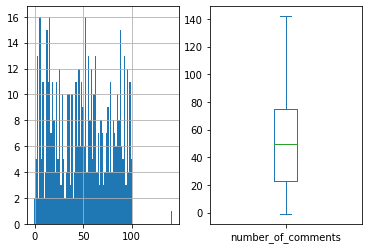

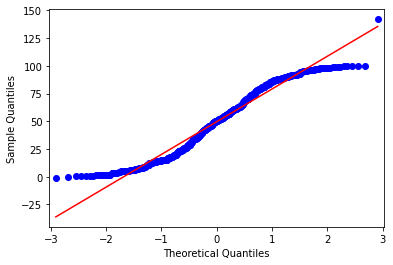

Outliers:
    user_id  number_of_comments
458     459                -1.0
42       43                 0.0
275     276               100.0
426     427               100.0
429     430               100.0
446     447               100.0
511    1000               100.0
543     544               142.0


count    550.000000
mean      49.618182
std       29.547770
min       -1.000000
25%       23.000000
50%       50.000000
75%       75.000000
max      142.000000
Name: number_of_comments, dtype: float64

<Figure size 432x288 with 0 Axes>

In [18]:
col='number_of_comments'
Q1 = df_outlier[col].quantile(0.01) #lower 1%
Q3 = df_outlier[col].quantile(0.99) #higher 1%

IQR = Q3 - Q1
xf = df_outlier[['user_id',col]][~((df_outlier[col] >= (Q1)) & (df_outlier[col] <= (Q3)))]
plt.subplot(1,2,1)
df_outlier[col].hist(bins=100)
plt.subplot(1,2,2)
df_outlier[col].plot(kind='box')
sm.qqplot(df_outlier[col],line='s')
pylab.show()
plt.tight_layout()
print('Outliers:')
print(xf.sort_values(by=col))
df_outlier[col].describe()

## Multivariate outlier detection approaches

### Visualize the dataset  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Size: 550
Sample: [3.1564e+04 9.1200e+02 1.8000e+01]


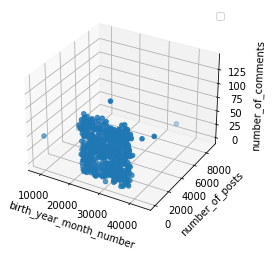

In [19]:

import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import pyplot as plt

df=df_outlier[['user_id','birth_year_month_number','number_of_posts','number_of_comments']]
x='birth_year_month_number'
y='number_of_posts'
z='number_of_comments'

def get_dataset():
    data = np.array(df.values)[:, 1:4]
    data=data.astype(float)
#     for i in range(3):
#         data[:, i] = (data[:, i] - np.mean(data[:, i])) / np.std(data[:, i])
    print('Size:', len(data))
    print('Sample:', data[0])
    return data

def plot_outlier(data):
	fig = plt.figure()
	ax = fig.add_subplot(111, projection='3d')
	ax.scatter(data[:, 0], data[:, 1], data[:, 2])
	ax.set_xlabel(x)
	ax.set_ylabel(y)
	ax.set_zlabel(z)
	ax.legend()
	plt.show()


if __name__ == "__main__":
	data = get_dataset()
	plot_outlier(data)

One-class SVM is an unsupervised algorithm that learns a decision function for novelty detection: classifying new data as similar or different to the training set.

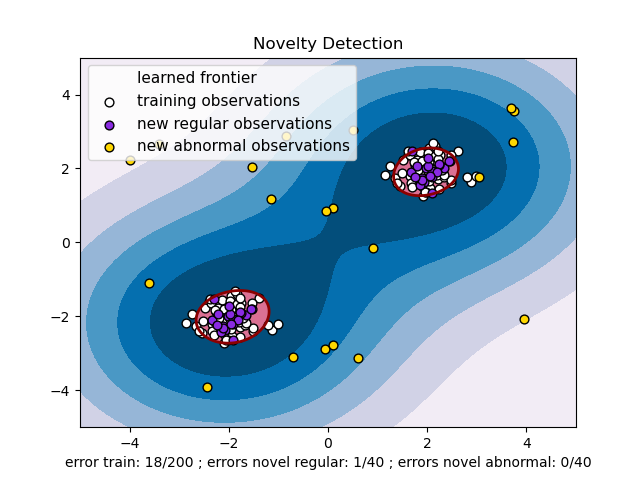

### Use OneClassSVM to detect the outliers in Multi-Dimentional data 

Size: 550
Sample: [3.1564e+04 9.1200e+02 1.8000e+01]
Time used: 0.01698923110961914
outlier: 13
[ 1.50188697 -0.61482822  0.96141452]


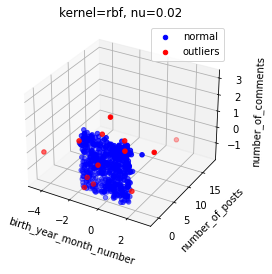

Outliers:


,user_id,birth_year_month,number_of_posts,number_of_comments,birth_year_month_number,outlier_indicator
25,26,2001-01-01,980.0,14.0,36892.0,-1.0
61,62,2020-07-01,925.0,95.0,44013.0,-1.0
63,64,1922-09-01,575.0,42.0,8280.0,-1.0
174,175,1978-04-01,813.0,53.0,28581.0,-1.0
214,215,1962-02-01,31.0,23.0,22678.0,-1.0
237,238,1967-10-01,635.0,98.0,24746.0,-1.0
247,248,1977-01-01,258.0,83.0,28126.0,-1.0
301,302,1992-02-01,254.0,45.0,33635.0,-1.0
413,414,1964-05-01,69.0,84.0,23498.0,-1.0
484,485,1966-05-01,230.0,14.0,24228.0,-1.0


In [20]:

from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
import time


def plot_outlier(data, outliers, rbf, nu):
	fig = plt.figure()
	ax = fig.add_subplot(111, projection='3d')
	print(data[10])
	ax.scatter(data[:, 0], data[:, 1], data[:, 2], color='b', label='normal')
	ax.scatter(outliers[:, 0], outliers[:, 1], outliers[:, 2], color='r', label='outliers')
	ax.set_xlabel(x)
	ax.set_ylabel(y)
	ax.set_zlabel(z)
	ax.legend()
	plt.title('kernel=%s, nu=%.2f' % (rbf, nu))
	plt.show()


def svdd(data, rbf, nu):
	# normalize
	for i in range(3):
		data[:, i] = (data[:, i] - np.mean(data[:, i])) / np.std(data[:, i])
	to_index = np.arange(len(data))

	# svm
	ocsvm = OneClassSVM(kernel=kernel, gamma='auto', tol=1e-3, nu=nu, shrinking=True, max_iter=-1)
	ocsvm.fit(data)
	pred = ocsvm.predict(data)
	normal = to_index[pred == 1]
	outliers = to_index[pred == -1]

	return data[normal], data[outliers], pred


if __name__ == "__main__":
    data = get_dataset()
#     kernel = 'linear'
    kernel = 'rbf'
    nu = 0.02
    
    start_time = time.time()
    normal, outliers, pred = svdd(data, rbf=kernel, nu=nu)
    print('Time used:', time.time() - start_time)
    print('outlier:', len(outliers))
    plot_outlier(normal, outliers=outliers, rbf=kernel, nu=nu)
    df_outlier['outlier_indicator']=pd.DataFrame(pred)
    print("Outliers:")
    display(df_outlier.query('outlier_indicator==-1'))

### Use LOF to detect the outliers in Multi-Dimentional data 

Time used: 0.0769507884979248
Outliers: 6


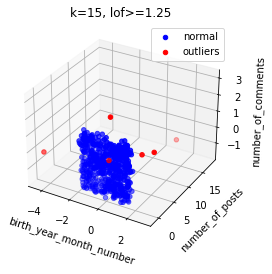

Outliers:


,user_id,birth_year_month,number_of_posts,number_of_comments,birth_year_month_number,outlier_indicator
47,48,1978-02-01,1332.0,51.0,28522.0,1.741974
61,62,2020-07-01,925.0,95.0,44013.0,2.475945
63,64,1922-09-01,575.0,42.0,8280.0,5.050463
217,218,1962-11-01,414.0,94.0,22951.0,1.518598
541,542,1994-06-01,285.0,74.0,34486.0,2.725668
547,548,1980-08-01,917.0,44.0,29434.0,25.140266


In [23]:
# from dataset import get_dataset
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import pyplot as plt
import numpy as np
import time

# data = get_dataset()
kdn = []  # list of k neighbor index
dis = []  # list of k neighbor distance
lrd = np.zeros(len(data))  # list of local reachability density
lof = np.zeros(len(data))  # list of lof


def plot_outlier(data, outliers=None, k=None, threshold=None):
	fig = plt.figure()
	ax = fig.add_subplot(111, projection='3d')
	ax.scatter(data[:, 0], data[:, 1], data[:, 2], color='b', label='normal')
	if outliers is not None:
		ax.scatter(outliers[:, 0], outliers[:, 1], outliers[:, 2], color='r', label='outliers')
	ax.set_xlabel(x)
	ax.set_ylabel(y)
	ax.set_zlabel(z)
	ax.legend()
	if k is not None and threshold is not None:
		plt.title('k=%d, lof>=%.2f' % (k, threshold))
	plt.show()


def distance(p):
	return np.sqrt(np.sum((p - data) ** 2, axis=1))


def k_distance_neighbor(p, k):
	dis = distance(p)
	idx = np.argsort(dis)
	for i in range(k + 1, len(idx)):
		if dis[idx[i]] <= dis[idx[i - 1]]:
			i += 1
		else:
			break
	idx = idx[1:i]
	return idx, dis[idx]


def local_reachability_density(index):
	rd = 0.
	for i in range(len(kdn[index])):
		rd += max(dis[index][i], dis[kdn[index][i]][-1])
	return len(kdn[index]) * 1.0 / rd


def local_outlier_factor(k, threshold):
	if k >= len(data):
		print('Wrong k!')
		exit()

	# get k neighbor index and distance
	global kdn, dis
	for i, d in enumerate(data):
		idx, distance = k_distance_neighbor(d, k)
		# index shows the order of k neighbors
		kdn.append(idx)
		# distance shows the distance of k neighbors
		dis.append(distance)

	# get lrd
	global lrd
	for i in range(len(data)):
		lrd[i] = local_reachability_density(i)

	# get lof
	global lof
	for i in range(len(data)):
		lof[i] = np.sum(lrd[kdn[i]]) * 1.0 / len(kdn[i]) / lrd[i]

	normal = lof < threshold
	outliers = lof >= threshold
	return normal, outliers, lof


if __name__ == "__main__":
    k = 15
    threshold = 1.25
    start_time = time.time()
    normal, outliers, pred = local_outlier_factor(k=k, threshold=threshold)
    print('Time used:', time.time() - start_time)
    print('Outliers:', len(data[outliers]))
    plot_outlier(data[normal], outliers=data[outliers], k=k, threshold=threshold)
    df_outlier['outlier_indicator']=pd.DataFrame(pred)
    print("Outliers:")
    display(df_outlier.query('outlier_indicator>=@threshold'))
    